<a href="https://colab.research.google.com/github/andreanlius/BelajarAngular/blob/main/DCTransformAndOTPEncryption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Discrete Cosine Transform and OTP Encryption**

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.fftpack import dct, idct
from random import *

Conversion function

In [ ]:
def resizeImage(image):
   return cv2.resize(image, (512, 512))

def rgb2gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)


DCT & IDCT Function

In [ ]:
# implement 2D DCT
def dct2(a):
    return dct(dct(a.T, norm='ortho').T, norm='ortho')

# implement 2D IDCT
def idct2(a):
    return idct(idct(a.T, norm='ortho').T, norm='ortho')

OTP Encryption & Decryption Function

In [ ]:
def otpEncryption(messageImage):
    width, height = messageImage.shape
    cipherImage = np.ndarray(messageImage.shape, dtype=int)
    key = np.ndarray(messageImage.size, dtype=int)
    count = 0
    for i in range(width):
        for j in range(height):
            key[count] = randint(0,messageImage[i][j])
            cipherImage[i][j] = (key[count] + messageImage[i][j])
            if cipherImage[i][j] > 255:
                cipherImage[i][j] -= 255
            count += 1
    return (key, cipherImage)

def otpDecryption(key, cipherImage):
    width, height = cipherImage.shape
    messageImage = np.ndarray(cipherImage.shape, dtype=int)
    count = 0
    for i in range(width):
        for j in range(height):
            messageImage[i][j] = cipherImage[i][j] - key[count]
            if messageImage[i][j] <= 0 and key[count] > 0:
                messageImage[i][j] += 255
            count += 1
    return messageImage

Convert Image to SubBlock (and vice versa)

In [ ]:
def convertImageToSubBlock(coverImage, shape):
    tiles = [coverImage[x:x+shape,y:y+shape] for x in range(0,coverImage.shape[0],shape) for y in range(0,coverImage.shape[1],shape)]
    return tiles

def convertSubBlockToImage(subBlock, shape):
    images = np.zeros((512,512))
    count = 0
    for i in range(0,images.shape[0], shape):
        for j in range(0, images.shape[1], shape):
            images[i:i+shape, j:j+shape] = subBlock[count]
            count +=1
    return images

Embedding Cipher Image to Sub Block

In [ ]:
def createDctSubBlock(subBlock):
    dctSB = list()
    for i in range(len(subBlock)):
        dctSB.append(dct2(subBlock[i]))
    return dctSB

def createDcCoefficientMatrix(dctSubBlock):
    dcCoefficientMatrix = np.zeros(len(dctSubBlock))
    for i in range(len(dctSubBlock)):
        dcCoefficientMatrix[i] = (dctSubBlock[i])[0][0]
    
    return np.reshape(dcCoefficientMatrix, (32,32))

def embedEncryptionMessageToDcCoefficientMatrix(cipherImage, dccMatrix, alpha = 1):
    return dccMatrix + (cipherImage * alpha)

def recoverEncryptionMessageFromDcCoefficientMatrix(dccStego, dccCover, alpha = 1):
    return dccStego - (dccCover * alpha)

def restoreDcCoefficientMatrixThenIdct(embeddedMatrix, dctSubBlock):
    embeddedList = embeddedMatrix.reshape(-1)
    idctSB = list()
    for i in range(len(embeddedList)):
        dctSubBlock[i][0][0] = embeddedList[i]
        idctSB.append(idct2(dctSubBlock[i]))
    return idctSB

Extract mesage from stegano image

In [ ]:
def extractingCopyRight(stegoImage, coverImage, key):
    coverSubBlock = convertImageToSubBlock(coverImage, 16)
    stegoSubBlock = convertImageToSubBlock(stegoImage, 16)

    coverDcCoefficient = createDcCoefficientMatrix(coverSubBlock)
    stegoDcCoefficient = createDcCoefficientMatrix(stegoSubBlock)

    encryptedMessage = recoverEncryptionMessageFromDcCoefficientMatrix(stegoDcCoefficient, coverDcCoefficient, 1)

    print(encryptedMessage)

    messageImage = otpDecryption(key, encryptedMessage)
    return messageImage

Main Program

In [ ]:
coverPath = '/content/lena.jpeg'
messagePath = '/content/message.jpg'

coverImage = rgb2gray(cv2.imread(coverPath))
messageImage = rgb2gray(cv2.imread(messagePath))

dctResult = dct2(coverImage)
idctResult = idct2(dctResult)
#Check if inverse dct result similar to original image
print("Check if inverse dct result similar to original image")
print(np.allclose(coverImage, idctResult))

encryptedTuple = otpEncryption(messageImage)

key = encryptedTuple[0]

cipherImage = encryptedTuple[1]

decryptedImage = otpDecryption(key, cipherImage)

print("Key")
print(key)


print("Check if message image similar to decrypted image")
print(np.allclose(messageImage, decryptedImage))


subBlock = convertImageToSubBlock(coverImage, 16)

dctSubBlock = createDctSubBlock(subBlock)

dcCoefficientMatrix = createDcCoefficientMatrix(dctSubBlock)

embeddedMatrix = embedEncryptionMessageToDcCoefficientMatrix(cipherImage, dcCoefficientMatrix, 0.5)

idctSubBlock = restoreDcCoefficientMatrixThenIdct(embeddedMatrix, dctSubBlock)

embeddedImage = convertSubBlockToImage(idctSubBlock, 16)

extractedImage = extractingCopyRight(embeddedImage, coverImage, key)

Check if inverse dct result similar to original image
True
Key
[ 51  98   2 ... 102 118  75]
Check if message image similar to decrypted image
True
[[1.5625  3.03125 0.0625  ... 7.40625 3.09375 3.0625 ]
 [5.28125 7.75    1.59375 ... 2.5     1.34375 1.3125 ]
 [2.09375 1.      6.4375  ... 2.5625  1.90625 2.8125 ]
 ...
 [2.25    4.78125 2.46875 ... 2.28125 6.75    0.65625]
 [3.8125  3.90625 1.25    ... 6.15625 7.75    1.375  ]
 [3.      4.09375 6.8125  ... 3.1875  3.6875  2.34375]]


Show result

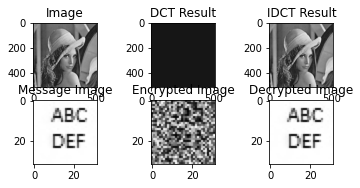

In [ ]:
Titles = ["Image", "DCT Result", "IDCT Result", "Message Image", "Encrypted Image", "Decrypted Image"]
images = [coverImage, dctResult, idctResult, messageImage, cipherImage, decryptedImage]


for i in range(6):
    plt.gray()
    plt.subplot(3, 3, i + 1)
    plt.title(Titles[i])
    plt.imshow(images[i])

Image and Embedded Image

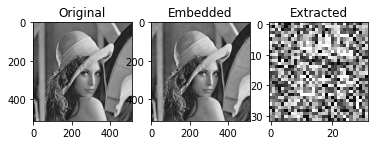

In [ ]:
titles = ["Original", "Embedded", "Extracted"]
images = [coverImage, embeddedImage, extractedImage]

for i in range(3):
    plt.gray()
    plt.subplot(1, 3, i + 1)
    plt.title(titles[i])
    plt.imshow(images[i])

plt.show()